In [33]:
import os
import pandas as pd
import glob

In [71]:
def merge_result(root, output_dir, binding_score_dir):
    merged_data = {}
    for file in glob.iglob(root, recursive=True):
        if os.path.isfile(file):
            chunk = pd.read_csv(file)
            chunk['energy'] = chunk[['E1', 'E2', 'E3']].min(axis=1)
            del chunk['E1'], chunk['E2'], chunk['E3']
            file = file.split('/')[-1]
            if file in merged_data:
                merged_data[file] = merged_data[file].append(chunk)
            else:
                merged_data[file] = chunk
    
    for file, data in merged_data.items():
        try:
            bs = pd.read_csv(os.path.join(binding_score_dir, file))
        except:
            continue
        bs['LigandName'] = bs['LigandName'].apply(lambda x : str(x).split('_')[-1])
        output_path = os.path.join(output_dir, file)
        data = data.dropna()
        # add binding score
        scores = []
        for row in data.iterrows():
            s = bs[bs['LigandName'] == row[1]['ligand']].iloc[0]['BindingScore']
            scores.append(s)
        data['binding score'] = scores
        data.to_csv(output_path, index=False)

In [72]:
merge_result('results-top-(200-100)/**', 'results-top-(200-100)/results/', 'binding-score/')

In [73]:
merge_result('results-top-(300-200)/**', 'results-top-(300-200)/results/', 'binding-score/')

In [75]:
merge_result('results-top-(400-300)/**', 'results-top-(400-300)/results/', 'binding-score/')

In [78]:
def accumulate_result(list_input_dir, output_dir):
    accumulated_data = {}
    for dir in list_input_dir:
        for file in os.listdir(dir):
            chunk = pd.read_csv(os.path.join(dir, file))
            if file in accumulated_data:
                accumulated_data[file] = accumulated_data[file].append(chunk)
            else:
                accumulated_data[file] = chunk
                
    for file, data in accumulated_data.items():
        output_path = os.path.join(output_dir, file)
        data = data.dropna()
        data.to_csv(output_path, index=False)

In [79]:
accumulate_result(['./results-top-100/results/', 
                   './results-top-(200-100)/results/'], 
                  './results/results-top-200/')

In [80]:
accumulate_result(['./results-top-100/results/', 
                   './results-top-(200-100)/results/', 
                   './results-top-(300-200)/results'], 
                  './results/results-top-300/')

In [81]:
accumulate_result(['./results-top-100/results/', 
                   './results-top-(200-100)/results/', 
                   './results-top-(300-200)/results/', 
                   './results-top-(400-300)/results/'], 
                  './results/results-top-400/')

# statistics

In [88]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
from scipy import stats
import matplotlib.pyplot as plt
import statistics

In [98]:
top = "100"
root = "./results/results-top-{}/"

## rank distribution

In [104]:
def plot_rank_distribution(top):
    root_dir = root.format(top)
    rank = []
    for file in os.listdir(root_dir):
        data = pd.read_csv(os.path.join(root_dir, file))
        index = data.index
        data_sorted = data.sort_values(by=['energy'])
        min_energy = data['energy'].min()
        
        r = 1000
        for i, row in enumerate(data.iterrows()):
            if row[1]['energy'] == min_energy:
                r = min(r, i)
        rank.append(r + 1)
        
    median = statistics.median(rank)
    plt.title("rank distribution")
    plt.xlabel("rank")
    plt.ylabel("frequency")
    plt.hist(rank)
    
    return median

91.5

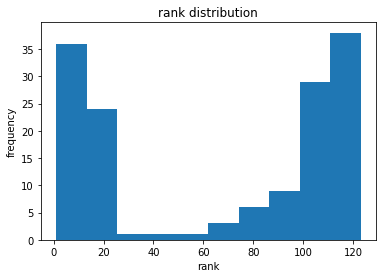

In [105]:
plot_rank_distribution(100)

121.0

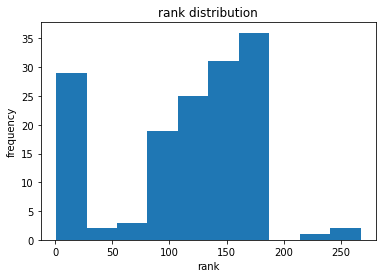

In [106]:
plot_rank_distribution(200)

148.0

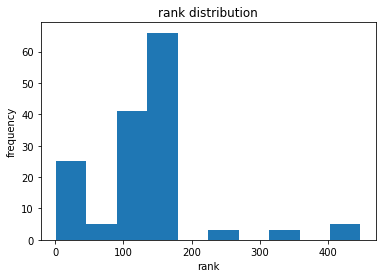

In [107]:
plot_rank_distribution(300)

154.5

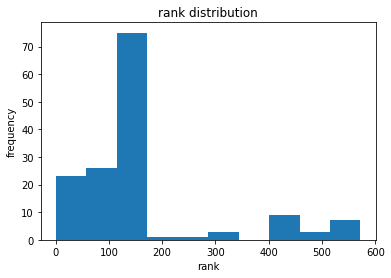

In [108]:
plot_rank_distribution(400)

## overlapping

In [122]:
def overlapping_score(top, top_overlap = 1):
    root_dir = root.format(top)
    scores = []
    for file in os.listdir(root_dir):
        data = pd.read_csv(os.path.join(root_dir, file))
        data = data.sort_values(by = ['binding score'], ascending=False)
        s1 = set(data[:top_overlap]['ligand'].tolist())
        s2 =  set(data[['ligand', 'energy']].sort_values(by=['energy'])['ligand'][:top_overlap])
        target = file.split('.')[-1]
        
        scores.append(len(s2 & s1) / len(s1))
        
    plt.title("overlapping distribution")
    plt.xlabel("target")
    plt.ylabel("overlapping score")
    plt.hist(scores)

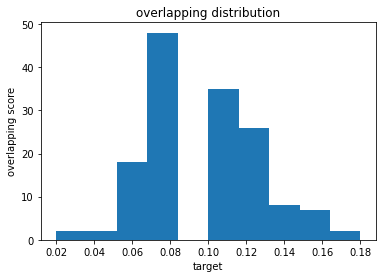

In [139]:
overlapping_score(400, 50)

## aggregation

In [132]:
def aggregation_ligand(top, top_ag=1, top_print=20):
    aggregation = {}
    root_dir = root.format(top)
    for file in os.listdir(root_dir):
        data = pd.read_csv(os.path.join(root_dir, file))
        data = data.sort_values(by=['energy'])[:top_ag]
        
        for row in data.iterrows():
            ligand = row[1]['ligand']
            if ligand in aggregation:
                aggregation[ligand] += 1
            else:
                aggregation[ligand] = 1
    aggregation = pd.DataFrame.from_dict(data=aggregation, orient='index', columns=['frequency'])
    aggregation = aggregation.sort_values(by=['frequency'], ascending=False)
    aggregation[:top_print].plot(kind='bar')

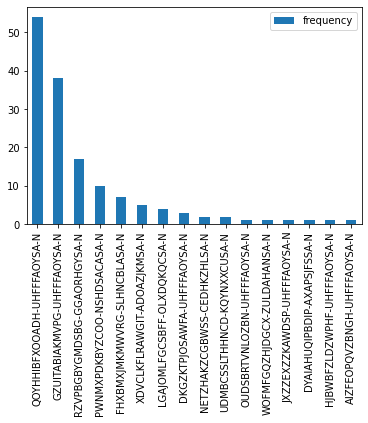

In [133]:
aggregation_ligand(top=100, top_ag=1, top_print=20)

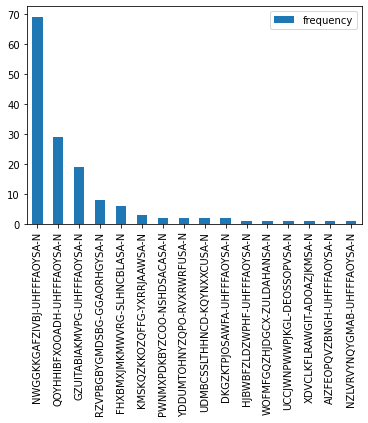

In [134]:
aggregation_ligand(top=200, top_ag=1, top_print=20)

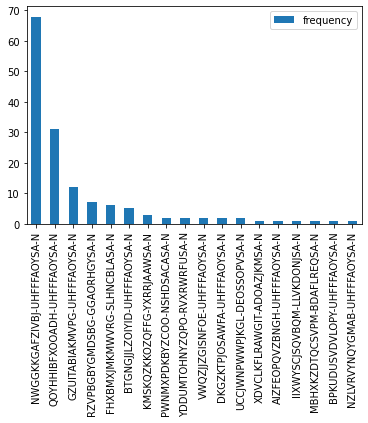

In [135]:
aggregation_ligand(top=300, top_ag=1, top_print=20)

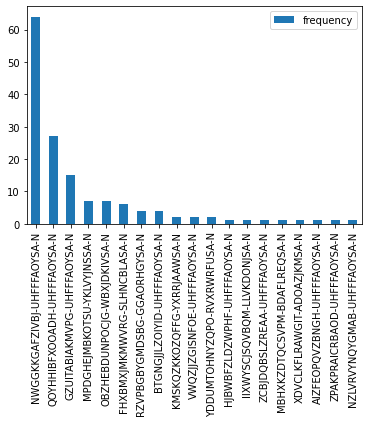

In [136]:
aggregation_ligand(top=400, top_ag=1, top_print=20)